In [3]:
import os
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"

import pandas as pd
import io
import matplotlib.pyplot as plt
import librosa
import random
import itertools

# import librosa.display
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
from tensorflow.keras.regularizers import l2
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pickle
import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers
import tensorflow.keras as keras
import tensorflow as tf
from datetime import datetime

import asyncio
import concurrent.futures
import functools

# settings
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.set_logical_device_configuration(physical_devices[0],[tf.config.LogicalDeviceConfiguration(memory_limit=3500)])




2023-06-19 13:48:59.375946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-19 13:49:00.733476: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


<h1>Audio ML with multiple features</h1>

<h2>Loading the Data</h2>

In [4]:
basePath = "/home/birdo/MachineLearning/Data/"

In [5]:
df = pd.read_csv(basePath + "bird_sounds.csv")

In [6]:
df

,recording_id,species_id
0,XC554370-ANAPLA_200229_5623_Fontbonne81_part_5...,Anas Platyrhynchos Linnaeus
1,XC605547-Wilde%20Eend%2020200621%202320%201a_p...,Anas Platyrhynchos Linnaeus
2,XC450266-20190105_165207%2B6%2C5sagcpato_part_...,Anas Platyrhynchos Linnaeus
3,XC618673-24_25_10_Anas_platyrrynchos_280_part_...,Anas Platyrhynchos Linnaeus
4,XC213601-magamo_fem_150215_sub_part_1.wav,Anas Platyrhynchos Linnaeus
...,...,...
89236,173192_part_0.wav,no bird
89237,39931_part_0.wav,no bird
89238,189268_part_0.wav,no bird
89239,146346_part_0.wav,no bird


In [7]:
df.species_id.unique()

array(['Anas Platyrhynchos Linnaeus', 'Phylloscopus Collybita',
       'Parus Major Linnaeus', 'Columba Palumbus Linnaeus',
       'Passer Domesticus', 'Turdus Merula Linnaeus',
       'Troglodytes Troglodytes', 'Phylloscopus Trochilus',
       'Fringilla Coelebs Linnaeus', 'Sturnus Vulgaris Linnaeus',
       'no bird'], dtype=object)

## Train/val/test split

In [5]:
allImPath = basePath + "Images/all/"
allLabelPath = basePath + "Labels/all/"
valid_files = []
labels = []
for img_file in os.listdir(allImPath):
    if os.path.isfile(allImPath + img_file) and os.path.isfile(allLabelPath + img_file):
        if os.path.isfile(allLabelPath + img_file):
            valid_files.append(img_file)
            f = open(allLabelPath + img_file, "r")
            label = f.read()
            f.close()
            labels.append(label)
        else:
            print("No label could be found of: " + img_file)
    else:
        continue 

X_train, X_test, y_train, y_test = train_test_split(
    valid_files, labels, test_size=0.2, random_state=42, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42, stratify=y_train
)  # 0.25 x 0.8 = 0.2
print(len(y_train), len(y_test), len(y_val))

53544 17849 17848


## Prepare data generators

In [7]:
NUM_DCT_OUTPUTS = 32
MFCC_SIZE = 310
CHANNELS = 1

In [8]:
class Sound_Generator(keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size, directory):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.imBasePath = basePath + str("Images/") + directory
        self.labelBasePath = basePath + str("Labels/") + directory
        self.executor = concurrent.futures.ThreadPoolExecutor(8)
        random.seed(42)

    def __get_all_labels__(self):
        y = np.asarray(self.labels, dtype=np.float32)
        return y

    def __on_epoch_end(self):
        c = list(zip(self.image_filenames, self.labels))
        random.shuffle(c)
        self.image_filenames, self.labels = zip(*c)

    def __len__(self):
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(
            np.int
        )

    def __getitem__(self, idx):
        batch_x = self.image_filenames[
            idx * self.batch_size : (idx + 1) * self.batch_size
        ]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]

        X = self.get_images_data(batch_x, self.imBasePath)

        X = np.asarray(X, dtype=np.float32)
        y0 = np.asarray(batch_y, dtype=np.float32)

        return X, y0

    def get_image_data(self,file_path):
        _data = np.fromfile(file_path, dtype=np.float64)
        return _data.reshape((MFCC_SIZE, NUM_DCT_OUTPUTS, CHANNELS))

    def get_images_data(self,_batch_x, _imBasePath):
        tasks = [
            self.executor.submit(self.get_image_data,_imBasePath + _image_f)
            for _image_f in _batch_x
        ]
        return [task.result() for task in tasks]

## Load an image

Turdus Merula Linnaeus-XC353083-1402_000-02tut%20mp3_part_7.npy
(310, 32, 1)


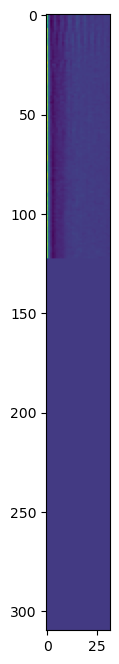

In [9]:
X_test_test = X_test[15000]
print(X_test_test)
image = np.fromfile((allImPath + X_test_test), dtype=np.float64).reshape(
    (MFCC_SIZE,NUM_DCT_OUTPUTS, CHANNELS)
)
print(image.shape)
plt.figure(figsize=(8, 8))
plt.imshow(image)

In [10]:
batch_size = 100

train_batch_generator = Sound_Generator(X_train, y_train, batch_size, "all/")
val_batch_generator = Sound_Generator(X_val, y_val, batch_size, "all/")
test_batch_generator = Sound_Generator(X_test, y_test, batch_size, "all/")
mini_train_batch_generator = Sound_Generator(
    X_train[:400], y_train[:400], batch_size, "all/"
)
mini_test_batch_generator = Sound_Generator(
    X_val[:100], y_val[:100], batch_size, "all/"
)

## Build the model

In [11]:
input_shape = (MFCC_SIZE, NUM_DCT_OUTPUTS, CHANNELS)
n_classes = df.species_id.unique().shape[0]
CNNmodel = models.Sequential()

CNNmodel.add(layers.Conv2D(8, kernel_size=(7,7),input_shape=input_shape, activation='tanh', padding='same', name='conv2d_tanh', kernel_regularizer=l2(0.001)))
CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
CNNmodel.add(layers.Dropout(rate=0.2, name='dropout_1'))

CNNmodel.add(layers.Conv2D(16, kernel_size=(5,5), activation='relu', padding='same', name='conv2d_relu_1',kernel_regularizer=l2(0.001)))
CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
CNNmodel.add(layers.Dropout(rate=0.2, name='dropout_2'))

CNNmodel.add(layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_2',kernel_regularizer=l2(0.001)))
CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_3'))
CNNmodel.add(layers.Dropout(rate=0.2, name='dropout_3'))

CNNmodel.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_3',kernel_regularizer=l2(0.001)))
CNNmodel.add(layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_4'))
CNNmodel.add(layers.Dropout(rate=0.2, name='dropout_4'))

CNNmodel.add(layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_4', kernel_regularizer=l2(0.001)))
CNNmodel.add(layers.Flatten(name='flatten'))
CNNmodel.add(layers.Dropout(rate=0.2, name='dropout_5'))

CNNmodel.add(layers.Dense(64, activation='relu', activity_regularizer=l2(0.001),kernel_regularizer=l2(0.001), name='dense'))
CNNmodel.add(layers.Dropout(rate=0.2, name='dropout_6'))
CNNmodel.add(layers.Dense(32, activation="relu", name='dense_2'))
CNNmodel.add(layers.Dense(n_classes, activation='softmax', name='softmax'))
CNNmodel.summary()

2023-06-19 11:49:54.920449: I tensorflow/core/common_runtime/gpu/gpu_process_state.cc:226] Using CUDA malloc Async allocator for GPU: 0
2023-06-19 11:49:54.920824: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3500 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:00:10.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_tanh (Conv2D)        (None, 310, 32, 8)        400       
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 155, 16, 8)        0         
                                                                 
 dropout_1 (Dropout)         (None, 155, 16, 8)        0         
                                                                 
 conv2d_relu_1 (Conv2D)      (None, 155, 16, 16)       3216      
                                                                 
 maxpool2d_2 (MaxPooling2D)  (None, 77, 8, 16)         0         
                                                                 
 dropout_2 (Dropout)         (None, 77, 8, 16)         0         
                                                                 
 conv2d_relu_2 (Conv2D)      (None, 77, 8, 16)         2

In [12]:
load_model = True
if load_model:
    CNNmodel = tf.keras.models.load_model(basePath + str("/Models/MFCCOnly"))
else:
    CNNmodel.compile(
        optimizer="adam",
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"],
        jit_compile=True,
    )

## Define tensorflow callback

In [13]:
log_dir = basePath + "logs/MFCCOnly/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,profile_batch='10, 15')
file_writer_cm = tf.summary.create_file_writer(log_dir + "/cm")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=basePath + str("/Models/MFCCOnly"),
    save_weights_only=False,
    monitor="val_accuracy",
    save_best_only=True,
)

2023-06-19 11:49:56.312753: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-06-19 11:49:56.312786: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.
2023-06-19 11:49:56.317948: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1679] Profiler found 1 GPUs
2023-06-19 11:49:56.350257: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.
2023-06-19 11:49:56.350444: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed


### Define Confusion Matrix callback

In [14]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """

    figure = plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    # cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    return figure

In [15]:
def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """

    buf = io.BytesIO()

    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format="png")

    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)

    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)

    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)

    return image

In [16]:
def log_confusion_matrix(epoch, logs):
    batch_generator = val_batch_generator

    figure = generate_cm(batch_generator)
    cm_image = plot_to_image(figure)

    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

In [17]:
def generate_cm(generator):
    y_pred_raw = CNNmodel.predict(generator)
    y_pred = np.argmax(y_pred_raw, axis=1)
    y_true = generator.__get_all_labels__()
    cm = confusion_matrix(y_true, y_pred)
    figure = plot_confusion_matrix(cm, class_names=df.species_id.unique())
    return figure

In [18]:
cm_callback = keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

## Calculate class weights

In [19]:
weights = []
for specie in df.species_id.unique():
    amount = len(df[df["species_id"] == specie])
    weight = (1 / amount) * (len(df) / len(df.species_id.unique()))
    weights.append(weight)
zip_weights = zip(range(0, len(df.species_id.unique())), weights)
class_weights = {}
for (
    i,
    w,
) in zip_weights:
    class_weights[i] = w
print(class_weights)

{0: 2.5787724672022194, 1: 1.2972206878506847, 2: 0.9040359016958082, 3: 2.0909325210871605, 4: 1.3541676150589521, 5: 0.5250335349351658, 6: 1.1275633331227495, 7: 0.3889547503029141, 8: 1.5746929700734047, 9: 1.2322020324754224, 10: 1.4096990759023773}


## Train the model

In [20]:
train_gen = train_batch_generator
val_gen = val_batch_generator

CNNmodel.fit(
    train_gen,
    epochs=32,
    verbose=1,
    validation_data=val_gen,
    callbacks=[tensorboard_callback, model_checkpoint_callback, cm_callback],
    class_weight=class_weights,
)

Epoch 1/32


2023-06-19 11:49:57.123863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-19 11:49:58.700383: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-06-19 11:49:59.118191: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-06-19 11:50:00.274815: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f4ae40240e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-19 11:50:00.274857: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecut

 12/536 [..............................] - ETA: 21s - loss: 0.7408 - accuracy: 0.8433

2023-06-19 11:50:04.194168: I tensorflow/tsl/profiler/lib/profiler_session.cc:104] Profiler session initializing.
2023-06-19 11:50:04.194215: I tensorflow/tsl/profiler/lib/profiler_session.cc:119] Profiler session started.


 14/536 [..............................] - ETA: 20s - loss: 0.7384 - accuracy: 0.8421

2023-06-19 11:50:04.479477: I tensorflow/tsl/profiler/lib/profiler_session.cc:70] Profiler session collecting data.
2023-06-19 11:50:04.483728: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_tracer.cc:1813] CUPTI activity buffer flushed
2023-06-19 11:50:04.497882: I tensorflow/compiler/xla/backends/profiler/gpu/cupti_collector.cc:541]  GpuTracer has collected 1803 callback api events and 1798 activity events. 
2023-06-19 11:50:04.513829: I tensorflow/tsl/profiler/lib/profiler_session.cc:131] Profiler session tear down.


536/536 [==============================] - ETA: 0s - loss: 0.7783 - accuracy: 0.8065

2023-06-19 11:50:43.219757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-19 11:51:03.969299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,155,16,8]
	 [[{{node inputs}}]]
2023-06-19 11:51:03.989030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,77,8,16]
	 [[{{node inputs}}]]
2023-06-1

INFO:tensorflow:Assets written to: /home/birdo/MachineLearning/Data//Models/MFCCOnly/assets


INFO:tensorflow:Assets written to: /home/birdo/MachineLearning/Data//Models/MFCCOnly/assets
2023-06-19 11:51:06.957013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


536/536 [==============================] - 77s 131ms/step - loss: 0.7783 - accuracy: 0.8065 - val_loss: 0.6736 - val_accuracy: 0.8340
Epoch 2/32
  3/179 [..............................] - ETA: 6s - loss: 0.7758 - accuracy: 0.810

2023-06-19 11:52:12.804666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


536/536 [==============================] - 65s 122ms/step - loss: 0.7758 - accuracy: 0.8100 - val_loss: 0.7011 - val_accuracy: 0.8268
Epoch 3/32
  5/179 [..............................] - ETA: 5s - loss: 0.7714 - accuracy: 0.8

2023-06-19 11:53:16.498952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


536/536 [==============================] - 64s 119ms/step - loss: 0.7714 - accuracy: 0.8085 - val_loss: 0.6851 - val_accuracy: 0.8302
Epoch 4/32
  3/179 [..............................] - ETA: 11s- loss: 0.7688 - accuracy: 0.80

2023-06-19 11:54:20.777472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


536/536 [==============================] - 64s 120ms/step - loss: 0.7688 - accuracy: 0.8097 - val_loss: 0.6981 - val_accuracy: 0.8259
Epoch 5/32
163/536 [========>.....................] - ETA: 22s - loss: 0.7666 - accuracy: 0.8081

KeyboardInterrupt: 

## Test the model

In [ ]:
conf_matrix = generate_cm(test_batch_generator)
plt.show()

In [ ]:
# Convert the model.


converter = tf.lite.TFLiteConverter.from_keras_model(CNNmodel)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32
converter.optimizations = {tf.lite.Optimize.DEFAULT}
# set too support only float32 input and output
converter.target_spec.supported_types = [tf.float32]



tflite_model = converter.convert()
# print size of model
print("Size of model: ", len(tflite_model) / 1024, " kb")

with open(basePath+'model.tflite', 'wb') as f:
  f.write(tflite_model)